# Truss element Response

In [1]:
import openseespy.opensees as ops
import opstool as opst
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
ops.wipe()
ops.model("basic", "-ndm", 2, "-ndf", 2)
# variables
A = 4.0
E = 29000.0
alpha = 0.05
sY = 36.0
udisp = 2.5
Nsteps = 1000
Px = 160.0
Py = 0.0
# create nodes
ops.node(1, 0.0, 0.0)
ops.node(2, 72.0, 0.0)
ops.node(3, 168.0, 0.0)
ops.node(4, 48.0, 144.0)
# set boundary condition
ops.fix(1, 1, 1)
ops.fix(2, 1, 1)
ops.fix(3, 1, 1)
# define materials
ops.uniaxialMaterial("Hardening", 1, E, sY, 0.0, alpha / (1 - alpha) * E)
# define elements
ops.element("Truss", 1, 1, 4, A, 1)
ops.element("Truss", 2, 2, 4, A, 1)
ops.element("Truss", 3, 3, 4, A, 1)
# create TimeSeries
ops.timeSeries("Linear", 1)
# create a plain load pattern
ops.pattern("Plain", 1, 1)
# Create the nodal load
ops.load(4, Px, Py)

OPSTOOL ::  Model data has been saved to _OPSTOOL_ODB/ModelData-None.nc!

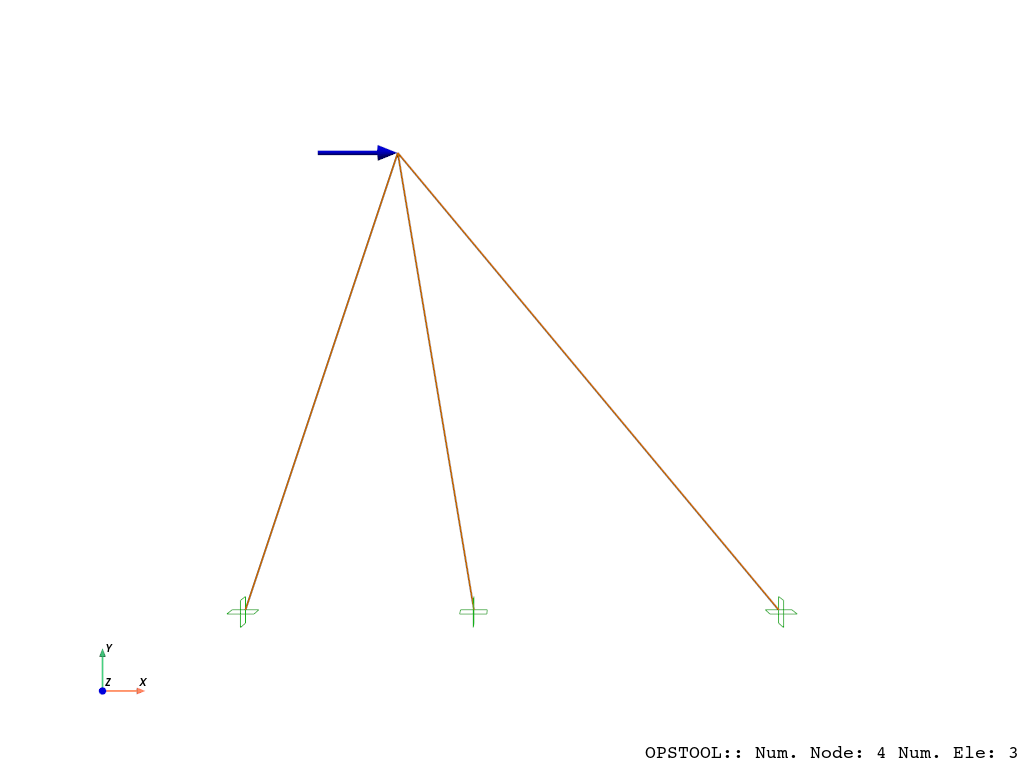

In [3]:
# plot
opst.vis.pyvista.set_plot_props(notebook=True)
fig = opst.vis.pyvista.plot_model(show_nodal_loads=True, load_scale=3, bc_scale=5)
fig.show(jupyter_backend="static")

## Result Saving

In [4]:
ops.system("BandGeneral")
ops.constraints("Transformation")
ops.numberer("RCM")
ops.test("NormDispIncr", 1.0e-12, 10, 3)
ops.algorithm("Newton")
ops.integrator("LoadControl", 1.0 / Nsteps)
ops.analysis("Static")

In [5]:
ODB = opst.post.CreateODB(odb_tag=1)
for i in range(Nsteps):
    ops.analyze(1)
    ODB.fetch_response_step()
ODB.save_response()

OPSTOOL ::  All responses data with _odb_tag = 1 saved in _OPSTOOL_ODB/RespStepData-1.nc!

## Result Reading

In [6]:
all_resp = opst.post.get_element_responses(odb_tag=1, ele_type="Truss")

OPSTOOL ::  Loading Truss response data from _OPSTOOL_ODB/RespStepData-1.nc ...

The result is an ``xarray DataSet`` object, and we can access the associated DataArray objects through ``.data_vars``.

In [7]:
all_resp.data_vars

Data variables:
    axialForce  (time, eleTags) float32 12kB 0.0 0.0 0.0 ... 162.8 -30.63 -161.7
    axialDefo   (time, eleTags) float32 12kB 0.0 0.0 0.0 ... -0.03855 -0.8036
    Stress      (time, eleTags) float32 12kB 0.0 0.0 0.0 ... 40.69 -7.658 -40.42
    Strain      (time, eleTags) float32 12kB 0.0 0.0 ... -0.0002641 -0.004287

The ``variable names``, along with their ``dimensions`` and ``coordinates``, are displayed above.
The first two represent the axial force and deformation of the truss element, while the latter refers to the stress and strain of the material in its cross-section.

In [8]:
all_resp["axialForce"]

<xarray.DataArray 'axialForce' (time: 1001, eleTags: 3)> Size: 12kB
array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.5702428e-01, -2.0976454e-02, -1.6697697e-01],
       [ 3.1404856e-01, -4.1952908e-02, -3.3395395e-01],
       ...,
       [ 1.6241649e+02, -3.0538671e+01, -1.6135800e+02],
       [ 1.6258820e+02, -3.0584375e+01, -1.6151137e+02],
       [ 1.6275992e+02, -3.0630081e+01, -1.6166473e+02]], dtype=float32)
Coordinates:
  * time     (time) float64 8kB 0.0 0.001 0.002 0.003 ... 0.997 0.998 0.999 1.0
  * eleTags  (eleTags) int32 12B 1 2 3

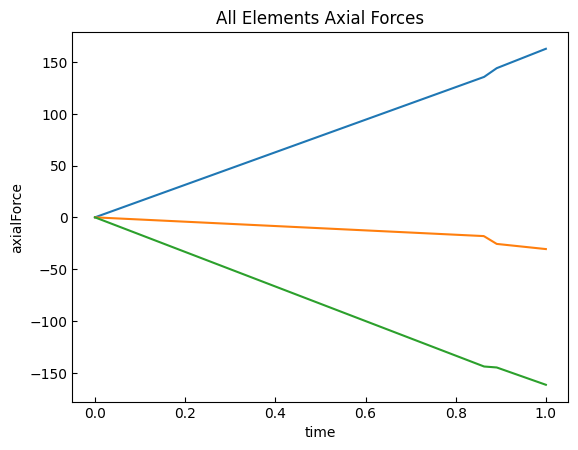

In [9]:
all_resp["axialForce"].plot.line(
    x="time",
    add_legend=False,
)
plt.title("All Elements Axial Forces")
plt.show()

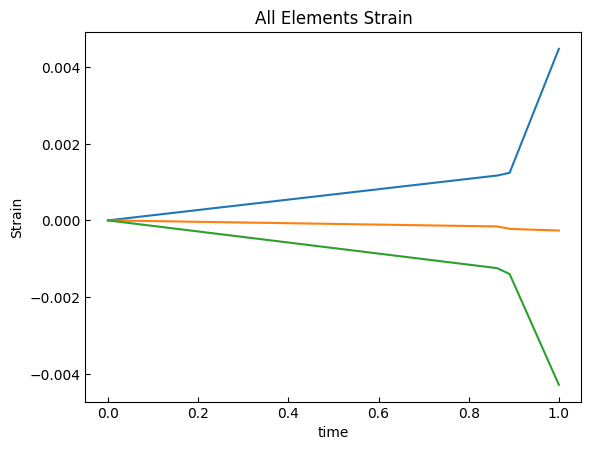

In [10]:
all_resp["Strain"].plot.line(
    x="time",
    add_legend=False,
)
plt.title("All Elements Strain")
plt.show()

OPSTOOL ::  Loading Truss axialForce response data from _OPSTOOL_ODB/RespStepData-1.nc ...

OPSTOOL ::  Loading Truss axialDefo response data from _OPSTOOL_ODB/RespStepData-1.nc ...

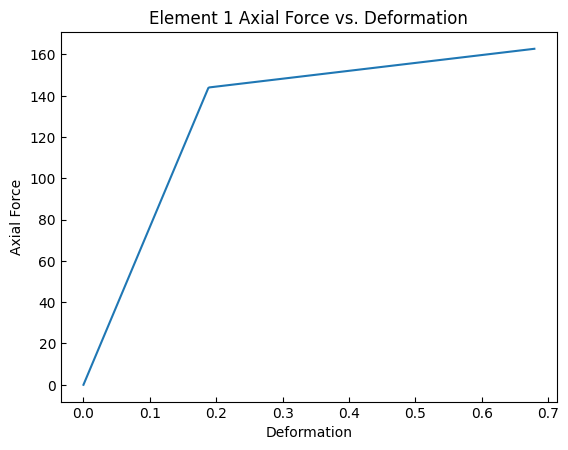

In [11]:
axialForce = opst.post.get_element_responses(odb_tag=1, ele_type="Truss", resp_type="axialForce")
axialDefo = opst.post.get_element_responses(odb_tag=1, ele_type="Truss", resp_type="axialDefo")

plt.plot(axialDefo.sel(eleTags=1), axialForce.sel(eleTags=1))
plt.title("Element 1 Axial Force vs. Deformation")
plt.xlabel("Deformation")
plt.ylabel("Axial Force")
plt.show()